In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import os
from tqdm import tqdm
import time
import numpy as np
import torch.utils.data as data
from skimage import io, transform, img_as_float
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
our_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                         (0.2724, 0.2608, 0.2669))
])
tr = transforms.ToPILImage()
BATCH_SIZE = 100
LEARNING_RATE = 0.01
classesNumber = 43 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=43):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def freeze_hidden_layers(self):
        self._freeze_layer(self.conv1)
        self._freeze_layer(self.bn1)
        self._freeze_layer(self.layer1)
        self._freeze_layer(self.layer2)
        self._freeze_layer(self.layer3)
        self._freeze_layer(self.layer4)

    def unfreeze_model(self):
        self._freeze_layer(self.conv1, freeze=False)
        self._freeze_layer(self.bn1, freeze=False)
        self._freeze_layer(self.layer1, freeze=False)
        self._freeze_layer(self.layer2, freeze=False)
        self._freeze_layer(self.layer3, freeze=False)
        self._freeze_layer(self.layer4, freeze=False)
        self._freeze_layer(self.linear, freeze=False)

    def embed_in_n_layer(self, n):
        self._freeze_layer(self.conv1)
        self._freeze_layer(self.bn1)
        if n == 1:
            self._freeze_layer(self.layer1)
        elif n == 2:
            self._freeze_layer(self.layer2)
        elif n == 3:
            self._freeze_layer(self.layer3)
        elif n == 4:
            self._freeze_layer(self.layer4)
        else:
            self._freeze_layer(self.linear)

    def _freeze_layer(self, layer, freeze=True):
        if freeze:
            for p in layer.parameters():
                p.requires_grad = False
        else:
            for p in layer.parameters():
                p.requires_grad = True

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3],classesNumber)
def ResNet18():
    return ResNet(PreActBlock, [2, 2, 2, 2],classesNumber)

In [ ]:
BB = ResNet34()
model_loader = torch.load('./drive/MyDrive/haha/BlackBox_20',map_location=torch.device('cpu'))
BB.load_state_dict(model_loader['model_state_dict'])

<All keys matched successfully>

In [ ]:
import pickle
testing_file = "./drive/MyDrive/haha/data_pickle/train.p"
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = test['features'], test['labels']

In [ ]:
def DataSet(X_train, y_train, transform):
    DataSet_len = np.shape(X_train)[0]
    dataset = []
    for i in range(DataSet_len):
        element = []
        sample = X_train[i]
        sample = img_as_float(sample)
        if(transform):
            sample = transform(sample)
        sample = sample.float()
        target = y_train[i]
        element.append(sample)
        element.append(int(target))
        dataset.append(element)
    return dataset

In [ ]:
trainingdataset = DataSet(X_train,y_train,our_transformation)
trainingDataLoader = torch.utils.data.DataLoader(trainingdataset, batch_size=100, shuffle=True)

In [ ]:
def train(trainloader,epochs=1, model=None):
    if model==None:
        model = ResNet34()
        model.to(device)
    loss_function=nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE) 
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images=images.to(device)
            labels=labels.to(device)
            optimizer.zero_grad() 
            preds = model(images)
            loss = loss_function(preds,labels)
            loss.backward() 
            optimizer.step() 
            total_loss += loss.item()
        del images
        del labels
    return model

In [ ]:
BB = train(trainingDataLoader,1)

100%|██████████| 1/1 [1:31:35<00:00, 5495.17s/it]


In [ ]:
import pickle
testing_file = "./drive/MyDrive/haha/data_pickle/test.p"
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']

In [ ]:
testingdataset = DataSet(X_test,y_test,our_transformation)
testingDataLoader = torch.utils.data.DataLoader(testingdataset, batch_size=1, shuffle=False)

In [ ]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(correct)
    return 100 * correct / total

In [ ]:
test(BB, testingDataLoader)

In [ ]:
torch.save({'model_state_dict':BB.state_dict(),},'./drive/MyDrive/haha/BlackBox_20')

In [ ]:
#big_tensor = torch.tensor()
for idx, (images, labels) in enumerate(testingDataLoader):
  images = images.to(device)
  labels = labels.to(device)
  if (idx == 0):
    first_numpy = BB(images).argmax(dim=1).numpy()
    second_numpy = labels.numpy()
  else:
    first_numpy = np.concatenate((first_numpy, BB(images).argmax(dim=1).numpy()),axis=0)
    second_numpy = np.concatenate((second_numpy,labels),axis=0)

In [ ]:
dic = {'features': first_numpy, 'labels':labels}
with open('./drive/MyDrive/haha/data_pickle/prediction', 'wb') as handle:
  pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("done from pickle")

done from pickle


In [ ]:
cmt = torch.zeros(43,43, dtype=torch.int64)

In [ ]:
for i in range(first_numpy[0]):
    tl, pl = first_numpy[i], second_numpy[i]
    cmt[tl, pl] = cmt[tl, pl] + 1

In [ ]:
cm = confusion_matrix(first_numpy, second_numpy)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes = [i for i in range(43)]

In [ ]:
plt.figure(figsize=(43,43))
plot_confusion_matrix(cm,classes)

In [ ]:
wrong_images = []
for idx, (images, labels) in enumerate(testingDataLoader):
  images = images.to(device)
  labels = labels.to(device)
  if(labels.item()!=BB(images).argmax(dim=1).item()):
    wrong_images.append(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

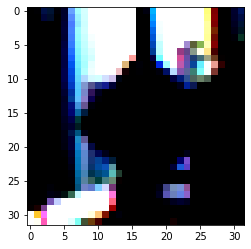

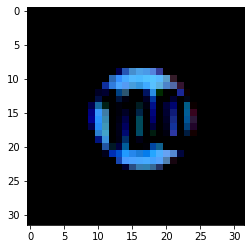

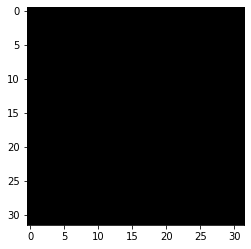

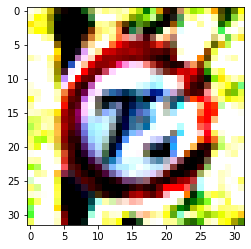

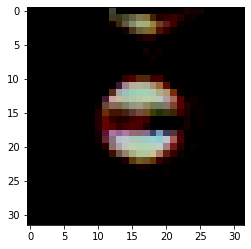

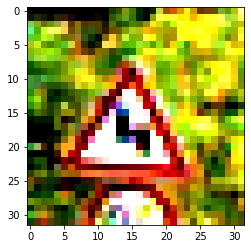

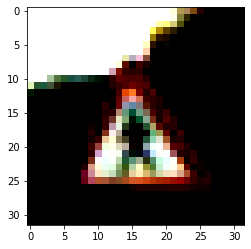

In [ ]:
for i in range(10,20):
  plt.figure()
  plt.imshow(wrong_images[i].squeeze(0).permute(1, 2, 0))